In [1]:
import os
import random
import numpy as np
import torch
import glob
import time
import matplotlib.pyplot as plt
from torch.autograd import Variable
from utils.architectures.autoreg import SimpleClass
from utils.architectures.inceptionv4 import InceptionV4
from sklearn.metrics import mean_squared_error as mse
from skimage.measure import compare_ssim as ssim
import natsort
import math
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [2]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    print(ret.shape)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def rescale(arr, scale=255):
    arr = arr.astype(np.float64)
    arr[arr<0] = 0
#     arr = arr - arr.min()
    arr = arr/arr.max()*scale
    return arr

def T1fromMRF(MRF, regressor, model, signal_length=999999, is_regressor=False, gpu="3"):
    device = torch.device("cuda:" + gpu)
    
    regressor.to(device)
    regressor.load_state_dict(torch.load(model))
    a = regressor.eval()

    MRF = MRF.reshape(1000,-1).T
    MRF = Variable(torch.from_numpy(MRF).type(torch.FloatTensor))
    MRF = MRF.to(device).view(-1,2,500)

    T1_array = np.array([])
    # break calculation into blocks so not to kill the GPU
    blocks = 128
#     blocks = 4096
    slice_len = int(np.ceil(MRF.size()[0]/blocks))
    max_len = len(MRF)
    for i in range(blocks):
        if i*slice_len >= max_len:
            break
        if i % (blocks//10) == 0:
            print(i)
            pass
        chunk = MRF[i*slice_len:(i+1)*slice_len]
        chunk = chunk[:,:,0:signal_length]
        T1 = regressor(chunk)
        if not is_regressor:
            T1 = T1.data.max(1)[1]
        T1 = T1.data.cpu().numpy()
        T1_array = np.concatenate((T1_array, T1.flatten()))

    print("mean: ", np.mean(T1_array))
    return T1_array.reshape(320,320)

# Generate DNN T1 reconstructions

In [3]:
i = 2

In [4]:
regressor = InceptionV4(num_classes=1)
model = "models/regL1T1"
MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_" + str(i) + ".npy")
T1_test = np.load("data/T1w_test/T1_norm_volunteer12_" + str(i) + ".npy")[0]

In [5]:
T1_recon = T1fromMRF(MRF, regressor, model, gpu="0", is_regressor=True)

0
12
24
36
48
60
72
84
96
108
120
mean:  2096.1201827219775


In [6]:
T1_recon.mean()

2096.1201827219775

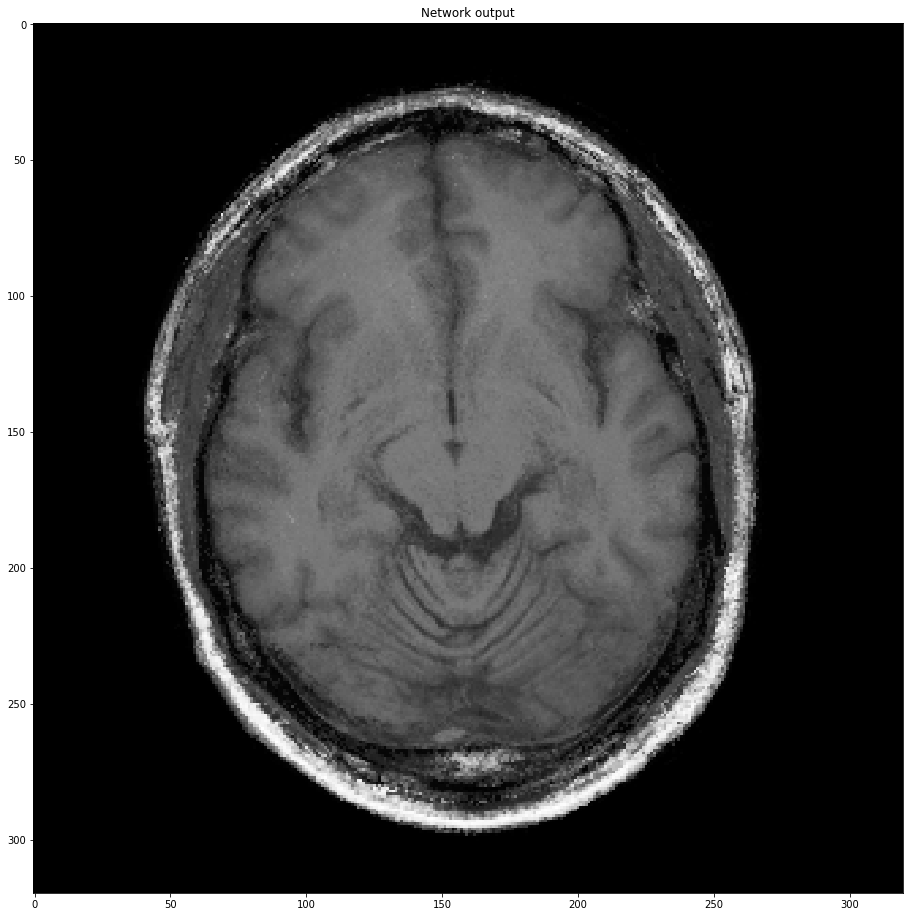

In [7]:
plt.figure(figsize=(16,16))
plt.title("Network output")
plt.imshow(T1_recon, cmap="gray")

In [8]:
mask = np.load("data/MRF_test_masks/MRF_norm_volunteer12_" + str(i) + ".npy")

# rescale to 0-255
T1_recon = rescale(T1_recon)
T1_test = rescale(T1_test)
MRF_T1 = rescale(np.load("outputs/MRF_dictionary_recon/MRF_norm_volunteer12_" + str(i) + "T1.npy"))

# mask
T1_recon[mask == 0] = 0

In [9]:
print(psnr(T1_recon, T1_test))
print(psnr(MRF_T1, T1_test))
print(psnr(MRF_T1, T1_recon))

19.964248206106053
17.420263773594083
20.329929094852307


In [10]:
print(ssim(T1_recon, T1_test))
print(ssim(MRF_T1, T1_test))
print(ssim(MRF_T1, T1_recon))

0.21508973592986314
0.16794109641637286
0.7370374634535534


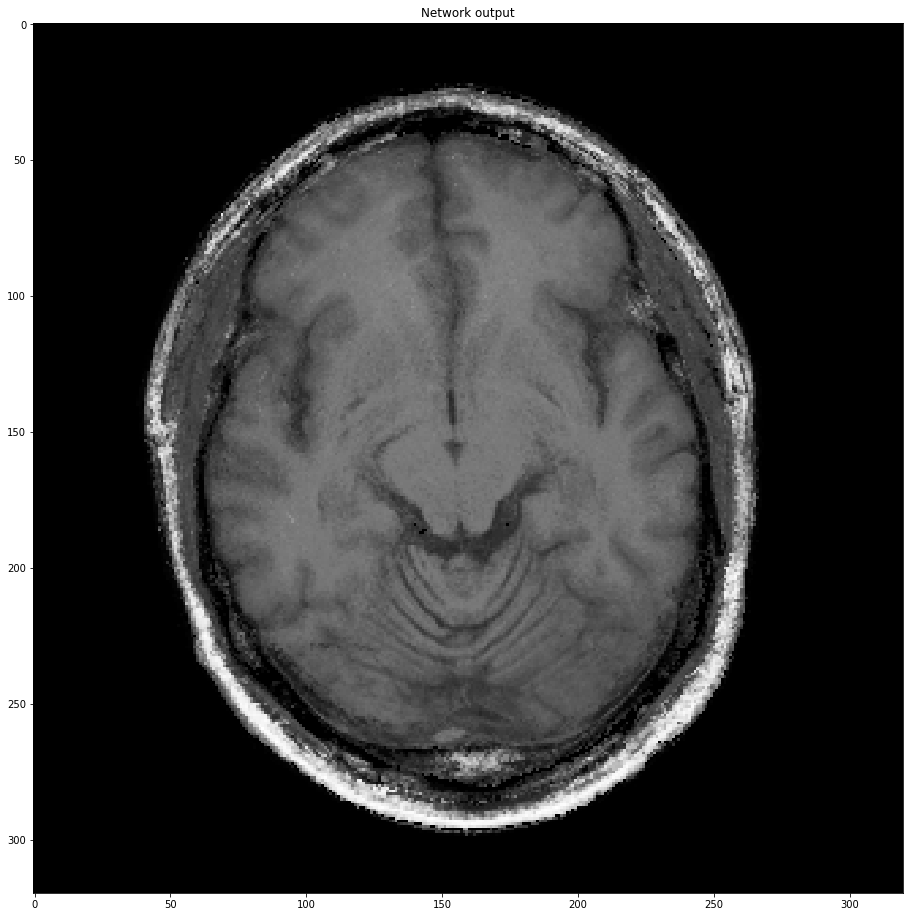

In [11]:
plt.figure(figsize=(16,16))
plt.title("Network output")
plt.imshow(T1_recon, cmap="gray",vmin=0,vmax=255)
plt.savefig(str(i) + model.split("/")[-1] + ".png")

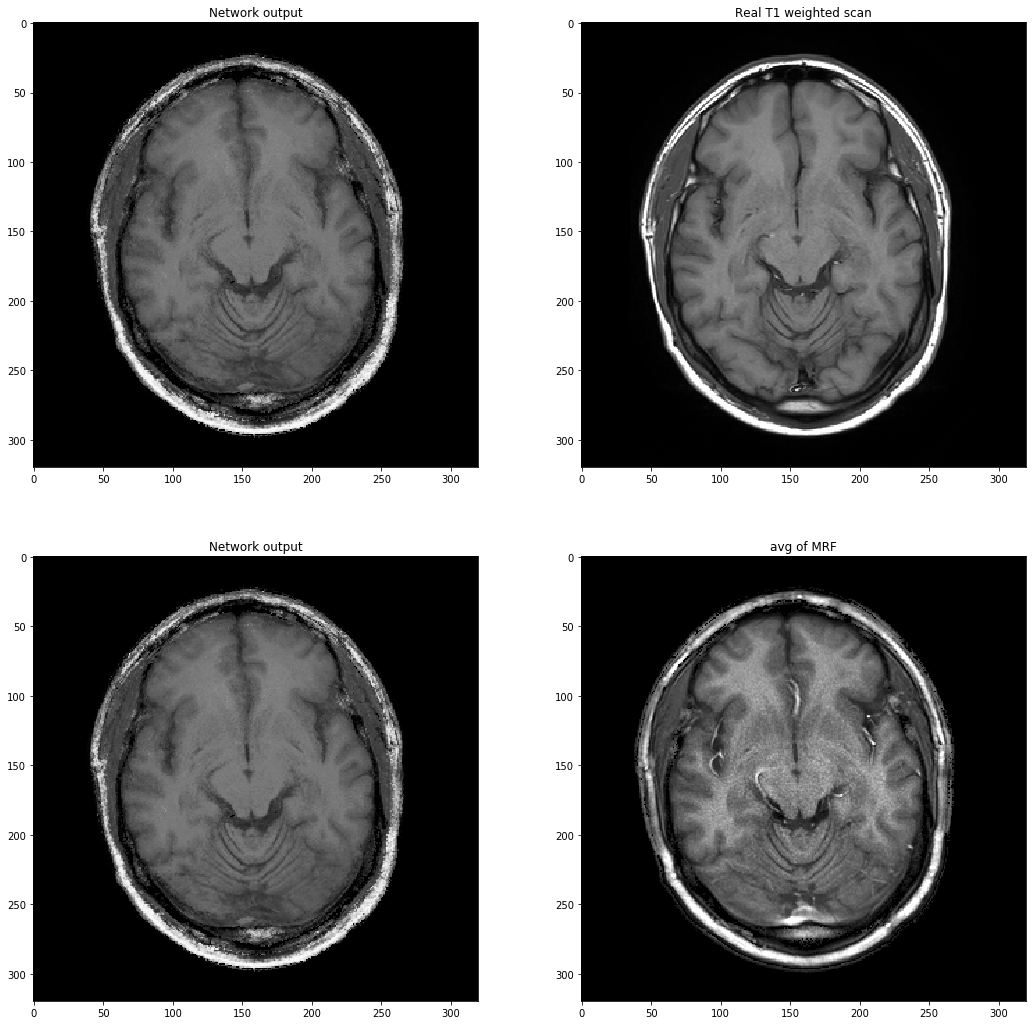

In [12]:
plt.figure(figsize=(18,18))
plt.subplot(2, 2, 1)
plt.title("Network output")
plt.imshow(T1_recon, cmap="gray", vmin=0, vmax=255)
# plt.colorbar()

plt.subplot(2, 2, 2)
plt.title("Real T1 weighted scan")
plt.imshow(T1_test, cmap="gray",vmin=0,vmax=255)

plt.subplot(2, 2, 3)
plt.title("Network output")
plt.imshow(T1_recon, cmap="gray",vmin=0,vmax=255)

plt.subplot(2, 2, 4)
plt.title("avg of MRF")
plt.imshow(MRF_T1, cmap="gray",vmin=0,vmax=255)

# plt.savefig("alpha0.75.png")

# Generate DNN T2 reconstructions

In [3]:
i = 1

In [4]:
regressor = InceptionV4(num_classes=1)
model = "models/regL1"
MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_" + str(i) + ".npy")
T2_test = np.load("data/T2w_test/T2_norm_volunteer12_" + str(i) + ".npy")[0]

In [5]:
T2_recon = T1fromMRF(MRF, regressor, model, gpu="0", is_regressor=True)

0
12
24
36
48
60
72
84
96
108
120
mean:  2078.6843080609674


In [6]:
mask = np.load("data/MRF_test_masks/MRF_norm_volunteer12_" + str(i) + ".npy")

# rescale to 0-255
T2_recon = rescale(T2_recon)
T2_test = rescale(T2_test)
MRF_T2 = rescale(np.load("outputs/MRF_dictionary_recon/MRF_norm_volunteer12_" + str(i) + "T2.npy"))

# mask
T2_recon[mask == 0] = 0

In [7]:
print(psnr(T2_recon, T2_test))
print(psnr(MRF_T2, T2_test))
print(psnr(MRF_T2, T2_recon))

17.496837396807738
14.54380148785301
18.32751848760806


In [8]:
print(ssim(T2_recon, T2_test))
print(ssim(MRF_T2, T2_test))
print(ssim(MRF_T2, T2_recon))

0.20760452826368977
0.1414569707739715
0.3054776706585217


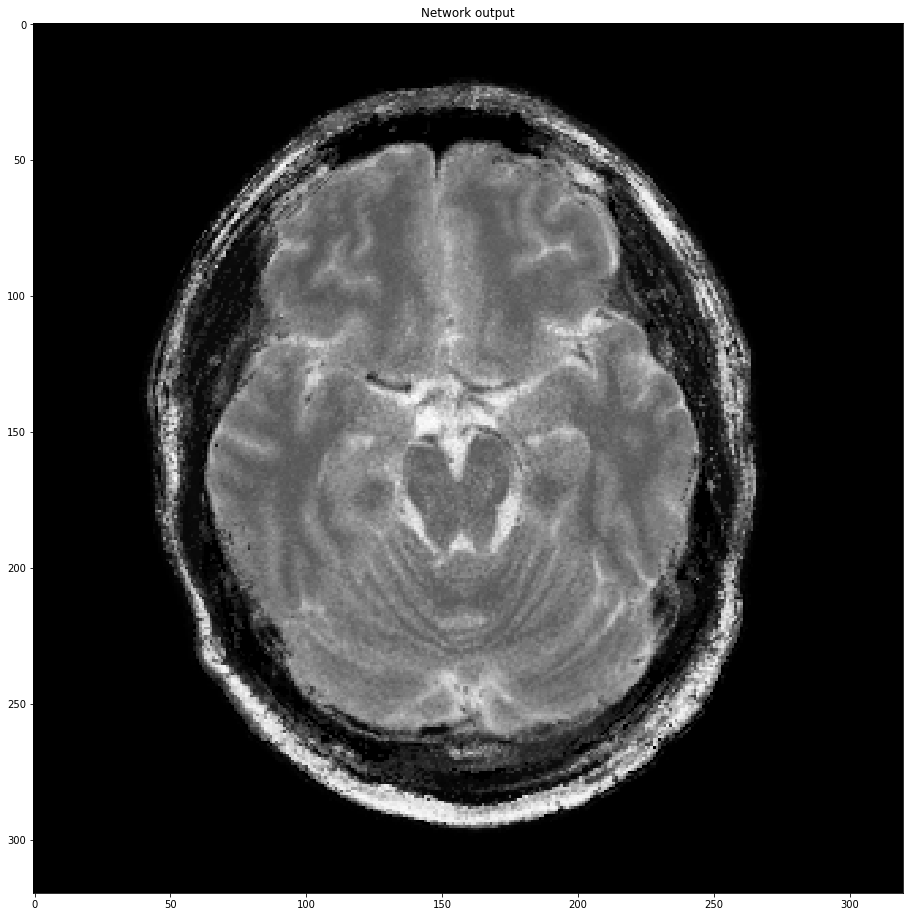

In [9]:
plt.figure(figsize=(16,16))
plt.title("Network output")
plt.imshow(T2_recon, cmap="gray",vmin=0,vmax=255)
plt.savefig(str(i) + model.split("/")[-1] + ".png")

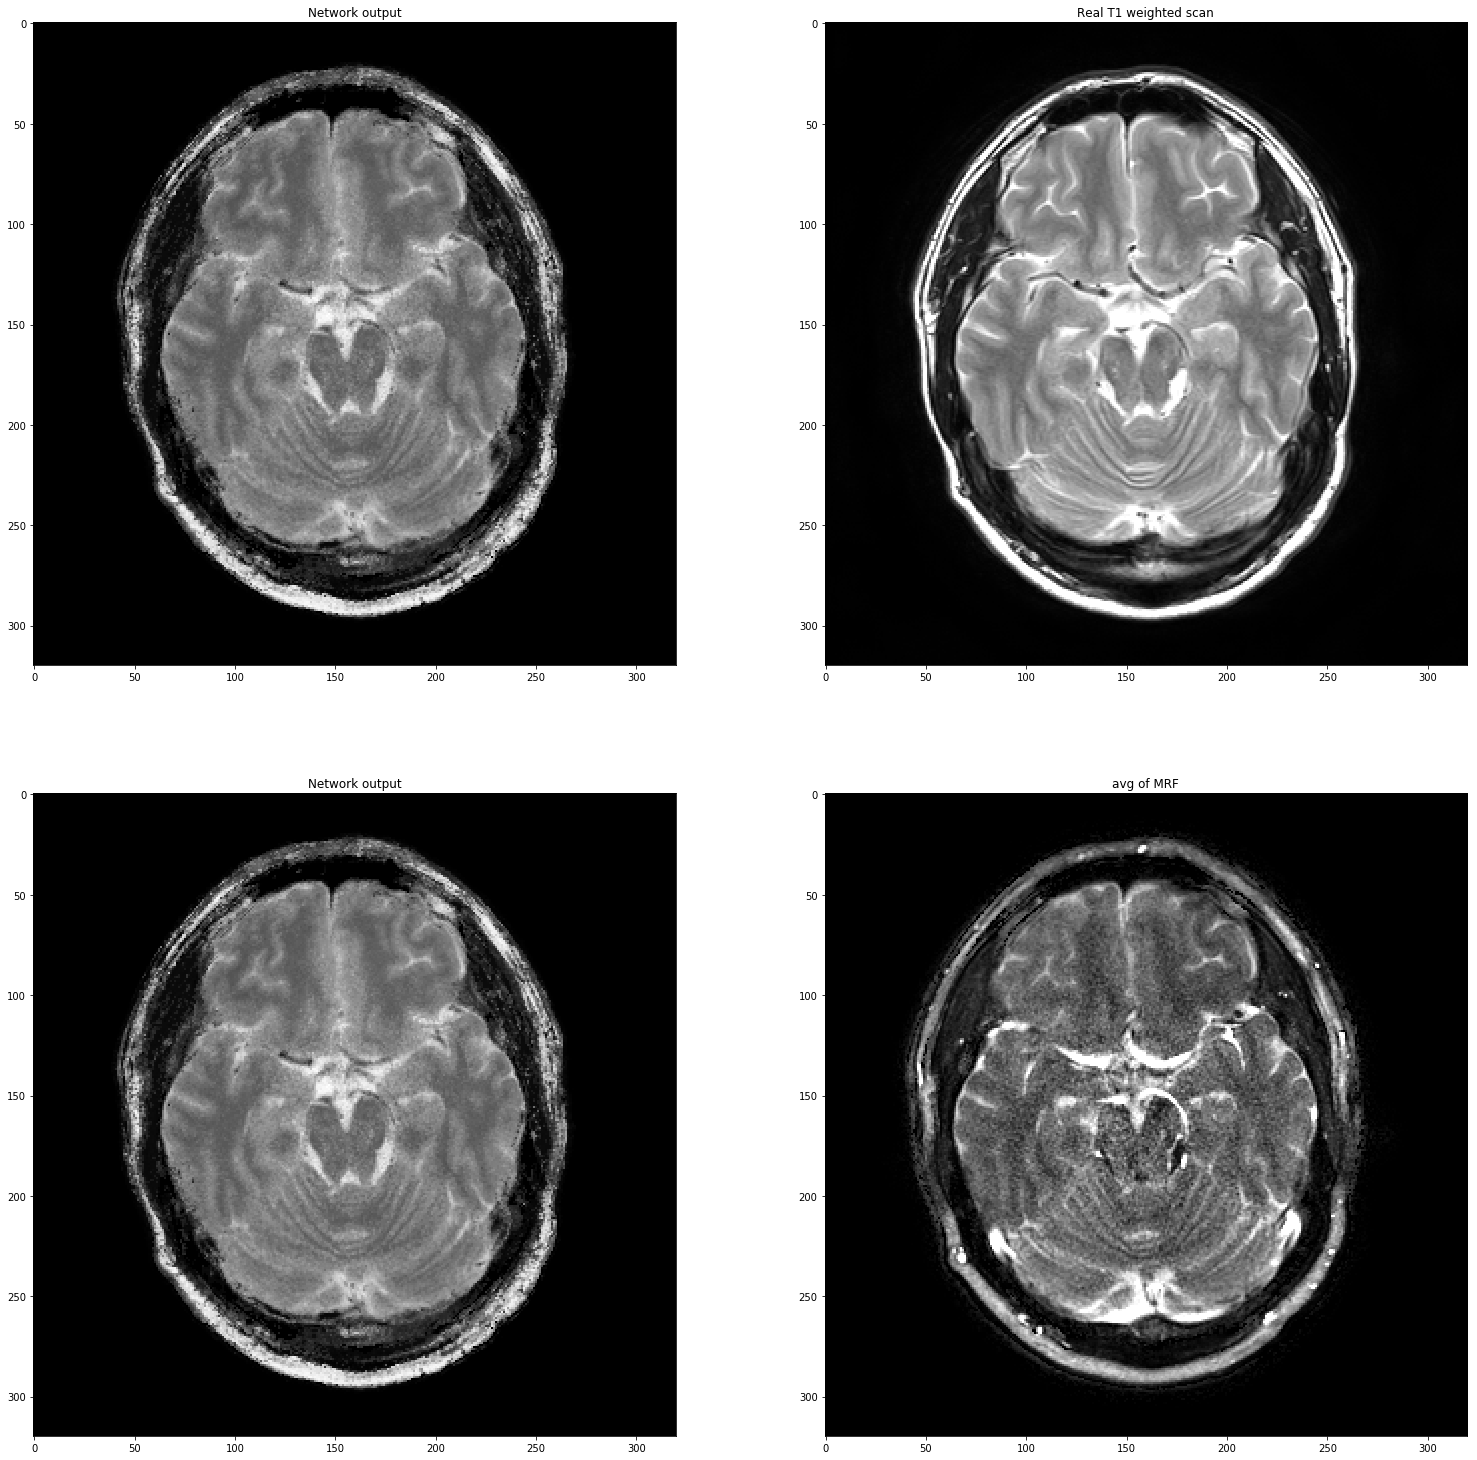

In [10]:
plt.figure(figsize=(26,26))
plt.subplot(2, 2, 1)
plt.title("Network output")
plt.imshow(T2_recon, cmap="gray", vmin=0, vmax=255)
# plt.colorbar()

plt.subplot(2, 2, 2)
plt.title("Real T1 weighted scan")
plt.imshow(T2_test, cmap="gray",vmin=0,vmax=255)

plt.subplot(2, 2, 3)
plt.title("Network output")
plt.imshow(T2_recon, cmap="gray",vmin=0,vmax=255)

plt.subplot(2, 2, 4)
plt.title("avg of MRF")
plt.imshow(MRF_T2, cmap="gray",vmin=0,vmax=255)

# plt.savefig("alpha0.75.png")